In [14]:
import numpy as np
import scipy as sp
import cvxopt as cp
import cvxpy as cpy
import matplotlib.pyplot as plt
import casadi as cas
plt.style.use('seaborn')

(CVXPY) Oct 06 03:58:06 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/Users/alessandroassirelli/anaconda3/lib/python3.11/site-packages/_scs_direct.cpython-311-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <A08A2CF9-B9A1-393C-A32E-68987F02C61E> /Users/alessandroassirelli/anaconda3/lib/python3.11/site-packages/_scs_direct.cpython-311-darwin.so\n  Reason: tried: '/Users/alessandroassirelli/anaconda3/lib/python3.11/site-packages/../../liblapack.3.dylib' (no such file), '/Users/alessandroassirelli/anaconda3/lib/python3.11/site-packages/../../liblapack.3.dylib' (no such file), '/Users/alessandroassirelli/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/Users/alessandroassirelli/anaconda3/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


/var/folders/lh/93lccf9x56l539tw7z9d404r0000gn/T/ipykernel_98185/208461429.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
# QP Formulation
S = 1000
ks = [1, 1, 0.5, 0.5, 0.5, 0.5]
kh = [2, 0.5, 0.5, 0.5, 0.5, 0.5]
n = 6

opti2 = cas.Opti()
U = opti2.variable(n*2)

A = np.zeros((2*n, 2*n))

for j in range(2*n):
    A[0, j] = 1 if (j % 2 == 0  and j + 2 != 2*n) else 0
    A[0, -1] = -1

for i in range(n - 1):
    for j in range(2 * n):
        if j == 2*i + 1:
            A[i + 1,j] = -1
        elif j % 2 == 0 and j != 2*i:
            A[i + 1,j] = 1

for i in range(0, n):
    for j in range(2*i, 2*n):
        A[n + i, j : j + 2] = np.array([1,1])
        break

b = np.zeros((2*n))
b[n:] = np.ones(n) * S

B = np.zeros((n, 2* n))
for i in range(0, n):
    for j in range(2*i, 2*n):
        B[i, j : j + 2] = np.array([kh[i] + ks[i], ks[i]])
        break

L = np.ones(n) * 100

life = L - B @ U

opti2.subject_to( A @ U - b == 0)
opti2.subject_to( U >= np.zeros((n*2,1)))

opti2.minimize(cas.sumsqr( cas.diff(life) ) )
# opti2.minimize(cas.sumsqr(B @ U)) 

p_opts = {"expand":True}
s_opts = {"max_iter": 10000}
opti2.solver('ipopt', p_opts, s_opts)

sol = opti2.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:       48
Number of nonzeros in inequality constraint Jacobian.:       12
Number of nonzeros in Lagrangian Hessian.............:       38

Total number of variables............................:       12
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       12
Total number of inequality c

In [29]:
# QP Formulation
S = 1000
ks = [1, 1, 0.5]
kh = [2, 0.5, 0.5]
n = 3


A = np.zeros((2*n, 2*n))

for j in range(2*n):
    A[0, j] = 1 if (j % 2 == 0  and j + 2 != 2*n) else 0
    A[0, -1] = -1

for i in range(n - 1):
    for j in range(2 * n):
        if j == 2*i + 1:
            A[i + 1,j] = -1
        elif j % 2 == 0 and j != 2*i:
            A[i + 1,j] = 1

for i in range(0, n):
    for j in range(2*i, 2*n):
        A[n + i, j : j + 2] = np.array([1,1])
        break

b = np.zeros((2*n))
b[n:] = np.ones(n) * S

P = np.zeros((2*n, 2* n))
for i in range(0, n):
    for j in range(2*i, 2*n):
        P[i, j : j + 2] = np.array([kh[i] + ks[i], ks[i]])
        break

q = np.ones(2*n) * 100
q[n:] = 0
G = np.eye(2*n)*-1
h = np.zeros(2*n)



In [9]:
from cvxopt import matrix
P = matrix(P, tc='d')
A = matrix(A, tc='d')
b = matrix(b, tc='d')
q = matrix(q, tc='d')
G = matrix(G, tc='d')
h = matrix(h, tc='d')

In [48]:
x = cpy.Variable(2*n)
obj = cpy.Maximize(0.5*cpy.sum(q - P@x))
constraints = [A@x == b, G@x <= h]

In [49]:
prob = cpy.Problem(obj, constraints)
sol = prob.solve()

In [50]:
x.value

array([2.86456497e-08, 1.00000000e+03, 5.00000000e+02, 5.00000000e+02,
       5.00000000e+02, 5.00000000e+02])

In [47]:
u = np.array(np.split(np.round(sol.value(U),0),n))
u = u[u[:, 1].argsort()]
s = np.arange(0, S, 1)
u_plt = np.zeros((n,S))

s_ = 0
for i in range(n):
    for k in range(s_, S):
        if u[i,0] + s_ > k:
            u_plt[i, k] = 1
        else: 
            s_ = k
            break
        

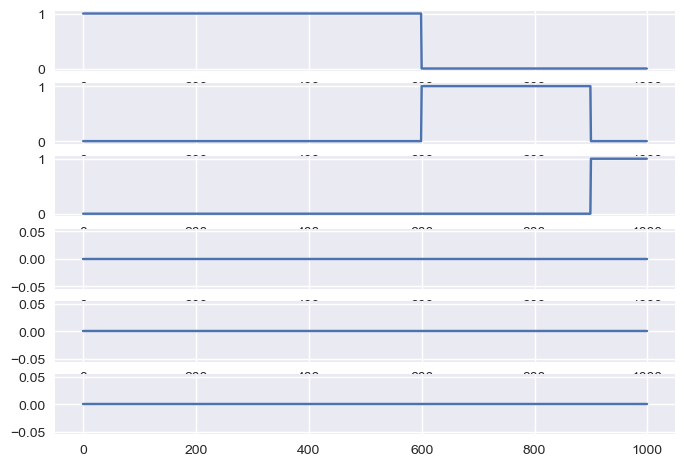

In [48]:
for i in range(n):
    plt.subplot(n,1,i+1)
    plt.plot(s, u_plt[i,:])